In [180]:
from pathinit import *

import numpy as np
import scipy as sc

import jax
import jax.numpy as jnp
import jax.scipy as jsc

from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian
import jaxopt
jax.config.update("jax_enable_x64", True)

import matplotlib as mpl
from matplotlib import pyplot as plt

import corner
import arviz as az
mpl.rcParams['font.size'] = 20

# Thème: pratiquer de nouveau de l'optimisation avec la librairie `jaxopt` ([doc](https://jaxopt.github.io/stable/index.html))

Soit le modèle 1D paramétré suivant:
$$
\Large
f(t) = R_0 + v t - \Theta(t)\times k(1-e^{t/\tau})\qquad avec \quad \Theta(t) = 1 (t>=0), 0 (t<0)
\\
$$
On va générer des données bruitées (`forward modeling`) puis on va effectuer de l'`inférence` (estimation).

In [16]:
def mean_fn(x, params):
    """Parametrisation avant et apres (t=0) """
    R0 = params["R0"]
    v  = params["v"]
    k  = params["k"]
    tau =  params["tau"]
    return jnp.piecewise(
        x, [x < 0, x >= 0],
        [lambda x: R0 + v*x, 
         lambda x: R0 + v*x - k*(1.-jnp.exp(-x/tau))
        ])

In [17]:
par_true={"R0":35.0, "v":2.20, "k":15.5, "tau": 1.0}
sigma_obs=1.0

In [18]:
rng_key = jax.random.PRNGKey(42)
rng_key, rng_key0, rng_key1, rng_key2 = jax.random.split(rng_key, 4)

In [25]:
#?jax.random.PRNGKey

Il est d'usage de prendre une clé et de la dupliquer, les clés peuvent être distribuées...

In [19]:
rng_key, rng_key0, rng_key1, rng_key2

(DeviceArray([2954079971, 2575172198], dtype=uint32),
 DeviceArray([1139032965, 1035738655], dtype=uint32),
 DeviceArray([3276725750, 1223413151], dtype=uint32),
 DeviceArray([173471767,  13772463], dtype=uint32))

In [20]:
tMes = jax.random.uniform(rng_key0,minval=-5.,maxval=5.0,shape=(20,))
tMes=jnp.append(tMes,0.0)
tMes=jnp.sort(tMes)

In [21]:
RMes = mean_fn(tMes,par_true) + sigma_obs * jax.random.normal(rng_key1,shape=tMes.shape)

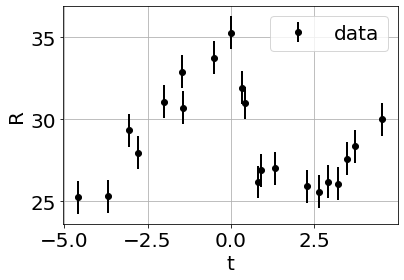

In [22]:
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.grid();

On se fixe un likelihood gaussien (log-likelihood quadratique) résidus normalisés par l'erreur de mesure

In [26]:
def lik(p,t,R, sigma_obs=1.0):
    params = {"R0":p[0], "v":p[1], "k":p[2], "tau": p[3]}
    resid = mean_fn(t, params)-R
    return 0.5*jnp.sum((resid/sigma_obs) ** 2) 

In [27]:
def get_infos(res, model, t,R):
    params    = res.params
    fun_min   = res.state.fun_val
    jacob_min =jax.jacfwd(model)(params, t,R)
    inv_hessian_min =jax.scipy.linalg.inv(jax.hessian(model)(params, t,R))
    return params,fun_min,jacob_min,inv_hessian_min

### Au lieu de faire une descente de gradient à la main on utilise la librairie `jaxopt` qui wrape certaines fonctions de `scipy.optimize` (voir le code [ici](https://github.com/google/jaxopt/blob/main/jaxopt/_src/scipy_wrappers.py) )

In [114]:
minimizer = jaxopt.ScipyMinimize(fun=lik,method='BFGS',options={'gtol': 1e-6,'disp': False})
init_params = jnp.array([18.,1.,10.,1.])
res1 = minimizer.run(init_params, t=tMes, R=RMes)
params,fun_min,jacob_min,inv_hessian_min = get_infos(res1, lik, t=tMes,R=RMes)
print("params:",params,"\nfun@min:",fun_min,"\njacob@min:",jacob_min,
     "\n invH@min:",inv_hessian_min)

params: [35.35772763  2.37101534 16.57772395  0.93055088] 
fun@min: 6.710174806788174 
jacob@min: [ 2.16257764e-07  2.81587047e-08 -7.97265823e-08  3.35171343e-07] 
 invH@min: [[ 0.30761634  0.09638602  0.63829182 -0.00407356]
 [ 0.09638602  0.04649244  0.26419768  0.00268039]
 [ 0.63829182  0.26419768  1.84093013  0.04456978]
 [-0.00407356  0.00268039  0.04456978  0.0111473 ]]


### On va profiter de l'auto-diff pour ploter la loss-landscape

In [36]:
def plot_landscape(ax,model,xdata,ydata, par_min, idx=(0,1), bounds=(0.,1.,0.,1.), model_args=(), model_kwargs={}):
    xmin,xmax,ymin,ymax = bounds
    grid = x0,y0 = jnp.mgrid[xmin:xmax:101j,ymin:ymax:101j]

    pts = jnp.swapaxes(grid,0,-1).reshape(-1,2)
    points = jnp.repeat(par_min[None, :], pts.shape[0], axis=0)
    for i in (0,1):
        points = points.at[:,idx[i]].set(pts[:,i])
    
    vfunc = jit(vmap(lambda p,x,y: model(p,x,y,*model_args, **model_kwargs), in_axes = (0,None,None)))
    v = vfunc(points,xdata,ydata)
    v = jnp.swapaxes(v.reshape(101,101),0,-1)
    g0=ax.contourf(x0,y0,v, levels = 100)
    ax.contour(x0,y0,v, levels = 50, colors = 'w')

    grid = jnp.mgrid[xmin:xmax:10j,ymin:ymax:10j]
    pts = jnp.swapaxes(grid,0,-1).reshape(-1,2)
    points = jnp.repeat(par_min[None, :], pts.shape[0], axis=0)
    for i in (0,1):
        points = points.at[:,idx[i]].set(pts[:,i])

    gradients = jit(vmap(
        grad(
            lambda p,x,y: model(p,x,y, *model_args, **model_kwargs)
        ), in_axes = (0,None,None)
    ))(points,xdata,ydata)

    scale = int(0.2*np.max(gradients))
    ax.quiver(
        points[:,idx[0]],
        points[:,idx[1]],
        gradients[:,idx[0]],
        gradients[:,idx[1]],
        color="white",
        angles = 'xy',
        scale_units='xy',
        scale = scale
    )
    ax.set_aspect("equal")
    fig.colorbar(g0,ax=ax,shrink=0.5)

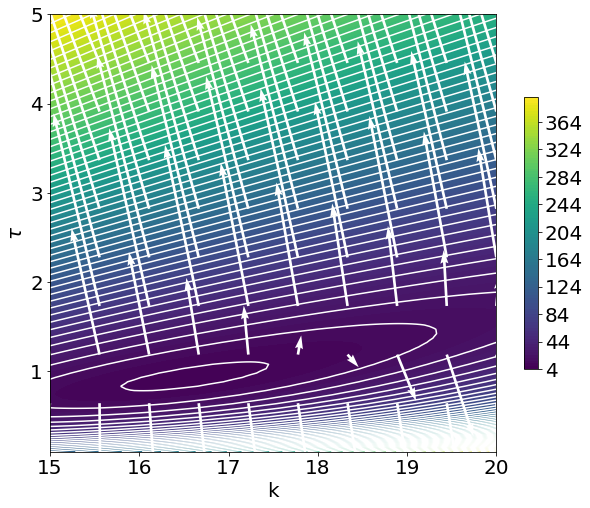

In [37]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plot_landscape(ax,model=lik,xdata=tMes,ydata=RMes,par_min=params, idx=(2,3),bounds=(15,20.,0.1,5.))
plt.xlabel("k")
plt.ylabel(r"$\tau$")
plt.show()

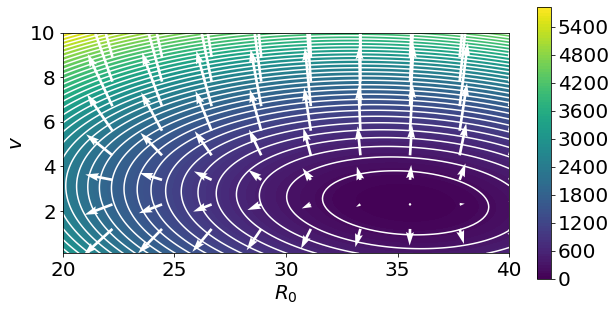

In [39]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plot_landscape(ax,model=lik,xdata=tMes,ydata=RMes,par_min=params, idx=(0,1),bounds=(20,40.,0.1,10.))
plt.xlabel(r"$R_0$")
plt.ylabel(r"$v$")
plt.show()

## Prédiction/error bands... 

In [48]:
t_val = np.linspace(-5,5,100)

In [49]:
Rtrue_val = mean_fn(t_val,par_true)

In [50]:
param_spls = jax.random.multivariate_normal(rng_key2,mean=params,cov=inv_hessian_min,shape=(1000,))

In [51]:
func = jax.vmap(lambda x: mean_fn(t_val,{"R0":x[0],"v":x[1],"k":x[2],"tau":x[3]}))

In [52]:
Rall_val= func(param_spls)

In [53]:
Rmean_val = jnp.mean(Rall_val,axis=0)

In [54]:
std_R_val = jnp.std(Rall_val,axis=0)

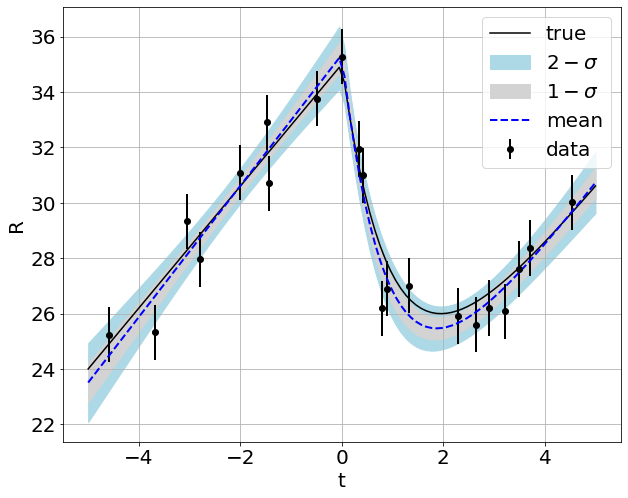

In [55]:
fig=plt.figure(figsize=(10,8))
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
plt.plot(t_val,Rtrue_val,c='k',label="true")

plt.fill_between(t_val, Rmean_val-2*std_R_val, Rmean_val+2*std_R_val, 
                    color="lightblue",label=r"$2-\sigma$")
plt.fill_between(t_val, Rmean_val-std_R_val, Rmean_val+std_R_val, 
                    color="lightgray",label=r"$1-\sigma$")
# plot mean prediction
plt.plot(t_val, Rmean_val, "blue", ls="--", lw=2.0, label="mean")


plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.grid();

## Etude du tmin (mminimum) pour $t>0$: 
$$
\Large
tmin=\tau \times \log\left(\frac{k}{v\tau}\right)
$$

In [62]:
#R0,v,k,tau
par_min = params
par_min

DeviceArray([35.35772763,  2.37101534, 16.57772395,  0.93055088], dtype=float64)

In [59]:
inv_hessian_min

DeviceArray([[ 0.30761634,  0.09638602,  0.63829182, -0.00407356],
             [ 0.09638602,  0.04649244,  0.26419768,  0.00268039],
             [ 0.63829182,  0.26419768,  1.84093013,  0.04456978],
             [-0.00407356,  0.00268039,  0.04456978,  0.0111473 ]],            dtype=float64)

In [67]:
#?jax.random.multivariate_normal

In [66]:
rgn_key, new_key = jax.random.split(rng_key)

In [83]:
samples = jax.random.multivariate_normal(new_key, mean=par_min, cov=inv_hessian_min, shape=(1000,)) 

In [84]:
samples = samples.T

In [91]:
def tmin(par):
    #par: R0,v,k,tau
    return par[3]*jnp.log(par[2]/par[3]/par[1])

In [92]:
tmins = tmin(samples)

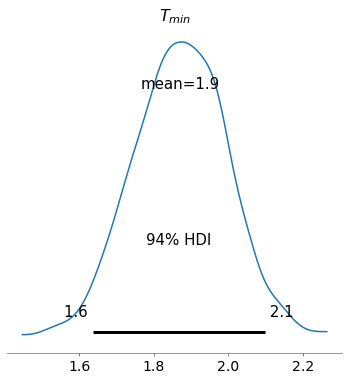

In [98]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
az.plot_posterior({"$T_{min}$":tmins},point_estimate='mean',ax=ax);

In [96]:
grad(tmin)(par_min)

DeviceArray([ 0.        , -0.39246936,  0.05613261,  1.01672011], dtype=float64)

# Contours plots: Fisher forecast
$$
\Large
F_{i,j} = \sum_{t:t_{mes}} \frac{1}{\sigma^2} \frac{\partial f(p_{true},t)}{\partial p_i}\frac{\partial f(p_{true},t)}{\partial p_j}
$$
généralisation dans le cas de données avec une matrice de covariance non-diagonale.

In [160]:
def f(p):
    par = {"R0":p[0], "v":p[1], "k":p[2], "tau":p[3]}
    return mean_fn(tMes,par) 

In [161]:
p_true = np.fromiter(par_true.values(), dtype=float)

In [162]:
p_true

array([35. ,  2.2, 15.5,  1. ])

In [163]:
jac = jax.jacfwd(f)(p_true)

In [164]:
jac.shape

(21, 4)

In [165]:
cov_inv = np.zeros((jac.shape[0],jac.shape[0]))
di = np.diag_indices(cov_inv.shape[0])
cov_inv[di]=1./sigma_obs**2

In [166]:
F = jnp.einsum('ia,ij,jb',jac,cov_inv,jac)
F = 0.5*(F+F.T)


In [167]:
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos, inds, nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  # Extracts the block we are interested in
  cov = cov[inds][::,inds]
  vals, vecs = eigsorted(cov)
  theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * np.sqrt(vals)
  ellip = Ellipse(xy=pos[inds], width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[inds[0]] - s1, pos[inds[0]] + s1)
  ax.set_ylim(pos[inds[1]] - s2, pos[inds[1]] + s2)
  plt.draw()
  return ellip

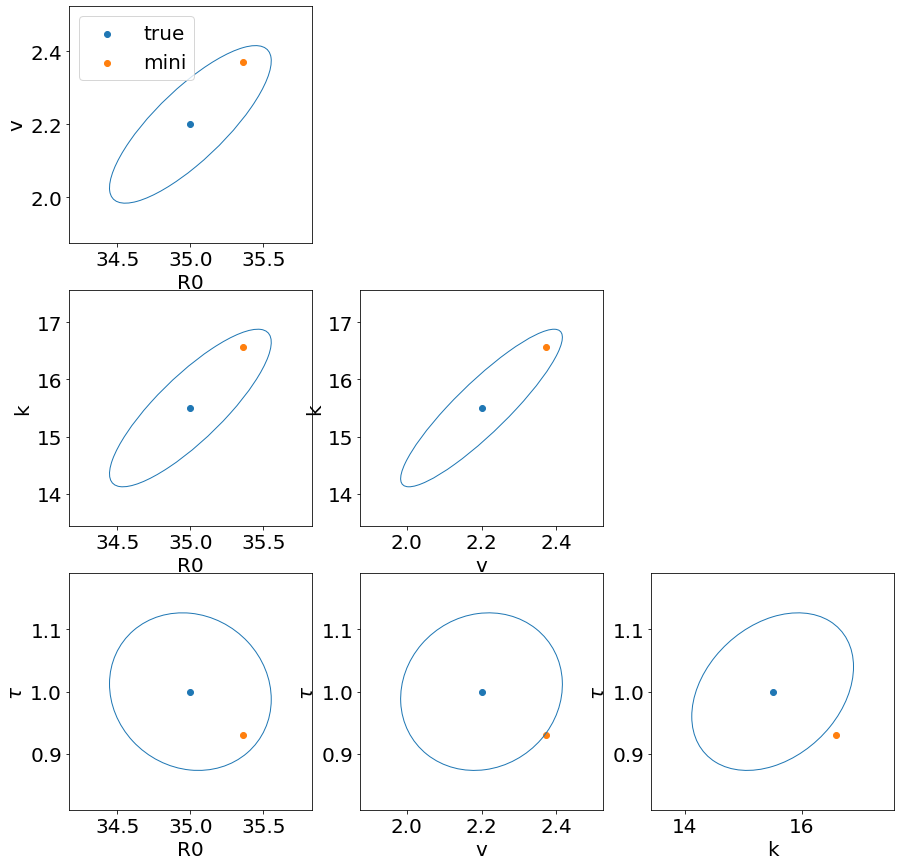

In [177]:
npar = p_true.shape[0]
pname = ["R0","v","k",r"$\tau$"]
plt.figure(figsize=(20, 20))
for i in range(1,npar):
    for j in range(npar):
        if j<i:
            plt.subplot(npar,npar,i*npar+j+1)
            plt.scatter(p_true[j],p_true[i], label="true")
            plt.scatter(par_min[j],par_min[i], label="mini")
            plt.xlabel(pname[j])
            plt.ylabel(pname[i])            
            plot_contours(F, p_true, [j,i],fill=False,color='C0')
            if j==0 and i==1: plt.legend()

# Minimisation avec contrainte

In [178]:
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_l2_ball, projection_box, projection_l1_ball, projection_polyhedron

In [179]:
#selle de cheval
def f(x):
    return x[0]**2-x[1]**2
# domaine : disque
def constraint(x,r):
    return jnp.atleast_1d(r**2 -((x[0]+1)**2 + (x[1]-1)**2))

In [183]:
# version avec Scipy
r=1.5
sc.optimize.minimize(f, np.array([1, 1]), bounds=((-3, 3), (-3, 3)), method='SLSQP',
         constraints={"fun": constraint, "type": "ineq", 'args': (r,)})

     fun: -5.623512131018319
     jac: array([-1.25599676, -4.90627933])
 message: 'Optimization terminated successfully'
    nfev: 27
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([-0.62799838,  2.45313964])

In [184]:
# Avec JaxOpt
def myproj1(x, hyper_params):
    radius = hyper_params   # attetion c'est bien le rayon...
    center = jnp.array([1,-1])
    x = projection_l2_ball(x + center, radius) - center
    return x

Text(0, 0.5, 'Y')

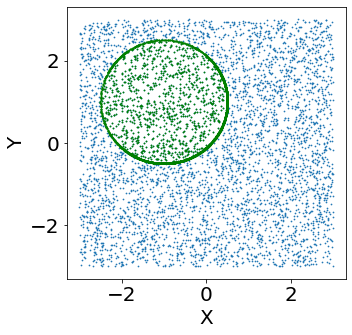

In [185]:
rng_key = jax.random.PRNGKey(42)
r=1.5
x = jax.random.uniform(rng_key, (5000,2), minval=-3,maxval=3)
p1_x=jax.vmap(myproj1, in_axes=(0,None))(x,r)
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x[:,0],x[:,1],s=0.5)
ax.scatter(p1_x[:,0],p1_x[:,1],s=0.5,c='g')
ax.set_xlabel("X")
ax.set_ylabel("Y")

In [191]:
pg=jaxopt.ProjectedGradient(fun=f,projection=myproj1)#, maxiter=1000, maxls=500)
res = pg.run(init_params=jnp.array([-1.,1.]), hyperparams_proj=r)
print(res.params, "\n", res.state)

[-0.62822889  2.45319863] 
 ProxGradState(iter_num=DeviceArray(5, dtype=int64, weak_type=True), stepsize=DeviceArray(1., dtype=float64, weak_type=True), error=DeviceArray(0.00027815, dtype=float64), aux=None, velocity=DeviceArray([-0.62741762,  2.45299148], dtype=float64), t=DeviceArray(3.8326014, dtype=float64, weak_type=True))


In [189]:
constraint(res.params,r), f(res.params)

(DeviceArray([-4.4408921e-16], dtype=float64),
 DeviceArray(-5.62351195, dtype=float64))

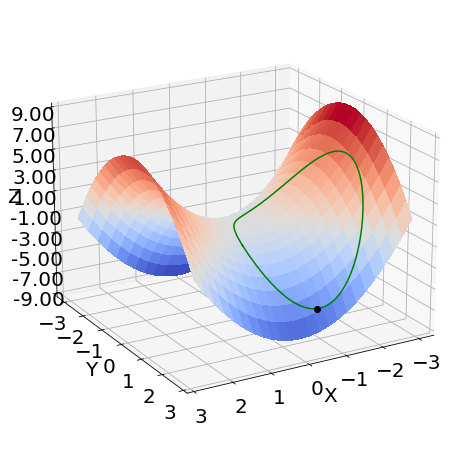

In [192]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))

# Make data.
X = np.arange(-3, 3, 0.25)
Y = np.arange(-3, 3, 0.25)
X, Y = np.meshgrid(X, Y)
Z = X**2-Y**2

# Make the image of the unit circle
r,xc,yc=1.5,-1.0,1.0
omega = np.linspace(0, 2*np.pi, 2048)
circ_X = r*np.cos(omega)+xc
circ_Y = r*np.sin(omega)+yc
circ_Z = circ_X**2 - circ_Y**2

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
circ = ax.plot(circ_X, circ_Y, circ_Z, color='green',zorder=3)

p_x = res.params[0]
p_y = res.params[1]
p_z = p_x**2 - p_y**2
ax.plot(p_x,p_y,p_z, 'ko', zorder=4)

ax.azim = 60
ax.dist = 10
ax.elev = 20


# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Exercices:
- Comment superposer aux contours Fisher Forecast les coutours obtenus au minimum?
*hint*: utiliser la matrice `inv_hessian_min`

- Utiliser le minimizer de descente de gradient simple du notebook `Jax-first-grad-vmap` et comparer.

- On a utiliser method='BFGS' mais il y en a d'autres, faire joujou avec les options de ScipyMinimize.

- Résoudre par la méthode des multiplicateurs de lagrange le problème d'optimisation suivant:

Soit une boite cubique de dimensions $(a,b,c)$, trouver les valeurs de ces paramètres pour obtenir **le plus grand volume**, sachant que **la surface extérieure totale** des 6 faces doit être **égale à 24**.

*hint*: il y a 4 paramètres $(a,b,c)$ et $\lambda$ le multiplicateur de Lagrange
```python
def vol(p):
    #le volume
def surf(p):
    #la surface totale
# la contrainte
def g(x): return surf(x) - 24 
# le lagrangien à optimiser
@jit
def Lag(p): 
    return vol(p[0:3]) - p[3]*g(p[0:3])

```

# Takeaway message:
- usage de `jaxopt` pour faire de l'optimisation 
- les gradients et matrice Hessienne sont calculés exactement ce qui consolide la détermination des paramètres et des contours.
- Fisher forecast: facile!
- version paramétrique d'une approximation d'observations